# Analyse Bevölkerungsbefragung Stadt Zürich

### Autorin: Tabea Eggler

# 1. Daten

### 1.1 Beschreibung der Daten

- Datensatz: Bevölkerungsbefragung der Stadt Zürich
- Zeitraum: 2019, 2021, 2023
- Analysierte Frageblöcke: Zufriedenheit mit den Einrichtungen und Angeboten der Stadt (F4) und Zufriedenheit mit den Gegebenheiten im Quartier (F25)
- Variabel Typen: Qualitativ/Kategorisch, Polytomous, Ordinal
- Variabel Levels: Überhaupt nicht zufrieden (1) - Sehr zufrieden (6), Weiss nicht, Keine Angabe

### 1.2 Selektion Variablen

Primäre Variable: Zufriedenheit Grünraum im Quartier (F25, A3016ae01)

Sekundäre Variablen:
- Zufriedenheit Angebot Grünanlagen und Parks (F4, A2004ac01)
- Zufriedenheit Freizeitgestaltung im Quartier (F25, A3016ad01)

Zusätzlich geladene Variable
- Jahr

### 1.3 Datensatz laden und strukturieren

In [28]:
# load libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
# load dataset

columns_to_load = [
    'A2004ac01', # satisfaction with greenspace in city
    'A3016ae01', # satisfaction with greenspace in district
    'A3016ad01', # satisfaction with leisure
    'Jahr'       # year
]

file_path = 'data/data_stez_2019_2023.csv'
df = pd.read_csv(file_path, usecols=columns_to_load)

In [3]:
# rename columns

df.rename(columns={
    'A2004ac01': 'Satisfaction_GreenSpace_City',
    'A3016ae01': 'Satisfaction_GreenSpace_District',
    'A3016ad01': 'Satisfaction_Leisure',
    'Jahr': 'Year'
}, inplace=True)

In [5]:
# mapping for ordinal data (object to numeric)

satisfaction_mapping = {
    'Note 1 (überhaupt nicht zufrieden)': 1,
    'Note 2': 2,
    'Note 3': 3,
    'Note 4': 4,
    'Note 5': 5,
    'Note 6 (sehr zufrieden)': 6,
    'Weiss nicht': -1,
    'Keine Angabe': -1
}

# apply mapping
ordinal_columns = ['Satisfaction_GreenSpace_City', 'Satisfaction_GreenSpace_District', 'Satisfaction_Leisure']
for col in ordinal_columns:
    df[col] = df[col].replace(satisfaction_mapping).astype(float)
    
    
df.head()

,Year,Satisfaction_GreenSpace_City,Satisfaction_Leisure,Satisfaction_GreenSpace_District
0,2019,5.0,3.0,3.0
1,2019,5.0,4.0,5.0
2,2019,6.0,6.0,6.0
3,2019,6.0,6.0,6.0
4,2019,5.0,6.0,6.0


In [6]:
# info about dataset

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15615 entries, 0 to 15614
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              15615 non-null  int64  
 1   Satisfaction_GreenSpace_City      15615 non-null  float64
 2   Satisfaction_Leisure              15615 non-null  float64
 3   Satisfaction_GreenSpace_District  15615 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 488.1 KB
None


In [7]:
# check for missing values

print(df.isnull().sum())

Year                                0
Satisfaction_GreenSpace_City        0
Satisfaction_Leisure                0
Satisfaction_GreenSpace_District    0
dtype: int64


# 2. Explorative Datenanalyse

### 2.1 Überischt Verteilung über Jahre (Grouped Bar Charts)

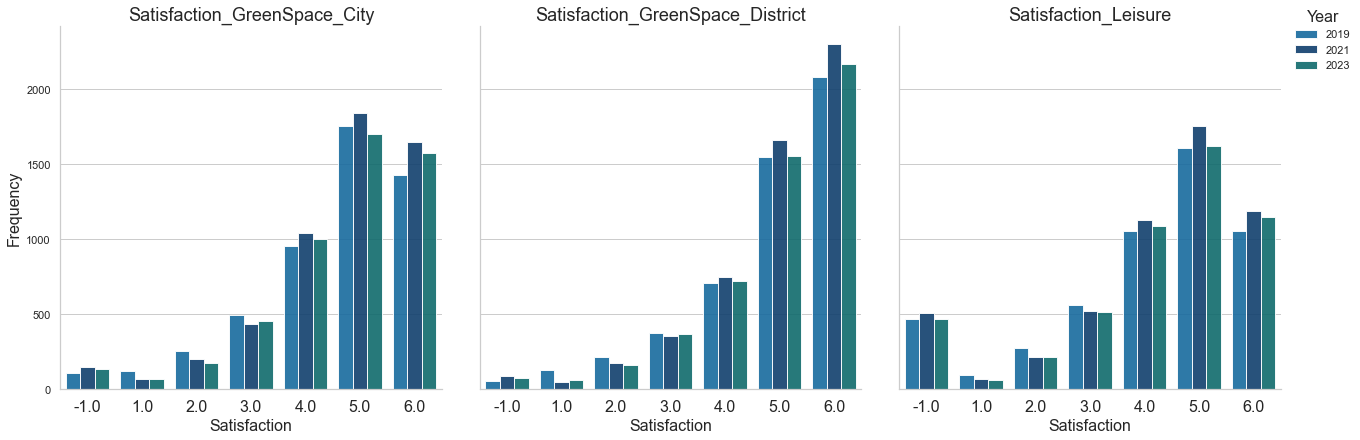

In [10]:
# reshape the data to long format
# long format: each row represents a single observation of satisfaction level for a given category and year
df_long = df.melt(id_vars=['Year'], value_vars=ordinal_columns, var_name='Variable', value_name='Satisfaction')

# count the occurrences of each satisfaction level for each year and category
df_counts = df_long.groupby(['Year', 'Variable', 'Satisfaction']).size().reset_index(name='Count')

# define the custom colors for the years based on based on https://www.zh.ch/de/webangebote-entwickeln-und-gestalten/inhalt/designsystem/design-grundlagen/farben.zhweb-noredirect.zhweb-cache.html?
year_colors = {
    2019: "#0070B4", 2021: "#00407C", 2023: "#00797B"
}

# create nested barplot
g = sns.catplot(
    data=df_counts, kind="bar",
    x="Satisfaction", y="Count", hue="Year",
    col="Variable", col_wrap=3,
    height=6, aspect=1, palette=year_colors, alpha=.9,
)

# adjust titles and label sizes
g.set_axis_labels("Satisfaction", "Frequency")
plt.subplots_adjust(wspace=0.1, hspace=0.5)
for ax in g.axes.flat:
    title = ax.get_title()
    ax.set_title(title.split('= ')[-1], fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
# adjust legend title and font size
for text in g.legend.texts:
    text.set_fontsize(16)  # font size legend text
g.legend.set_title("Year", prop={'size': 16})
sns.move_legend(g, "upper right")

plt.show()

#### Interpretation

Die Balkendiagramme visualisieren die Verteilung der Zufriedenheit über die ausgewählten Variablen. Auf der X-Achse sind die Zufriedenheitsstufen dargestellt, während die Y-Achse die Anzahl der Beobachtungen angibt. Die Balken sind nach Jahren gruppiert, um die Veränderungen über die Zeit darzustellen.

Über die drei Befragungen hinweg zeigen sich insgesamt nur geringe Unterschiede; die Trends der Zufriedenheit spiegeln sich bei allen drei Variablen ähnlich wider. Im Jahr 2021 lässt sich generell eine etwas höhere Zufriedenheit feststellen, wobei die Unterschiede minimal sind. Daher liegt der Fokus der weiteren Analysen auf dem aktuellen Jahr 2023.

Die Stadtbevölkerung zeigt eine hohe Zufriedenheit mit den Grünanlagen. Es ist erkennbar, dass die Zufriedenheit mit dem Grünraum im Quartier im Vergleich zu den Grünanlagen und Parks in der Stadt Zürich generell höher ist. Die Zufriedenheit mit der Freizeitgestaltung im Quartier wird etwas schlechter bewertet als die beiden anderen Variablen, wobei viele Befragte Enthaltungen oder Unentschiedenheiten angegeben haben.

### 2.2 Zusammenhänge der Variablen im Jahr 2023 (Contingency Table as Heatmap)

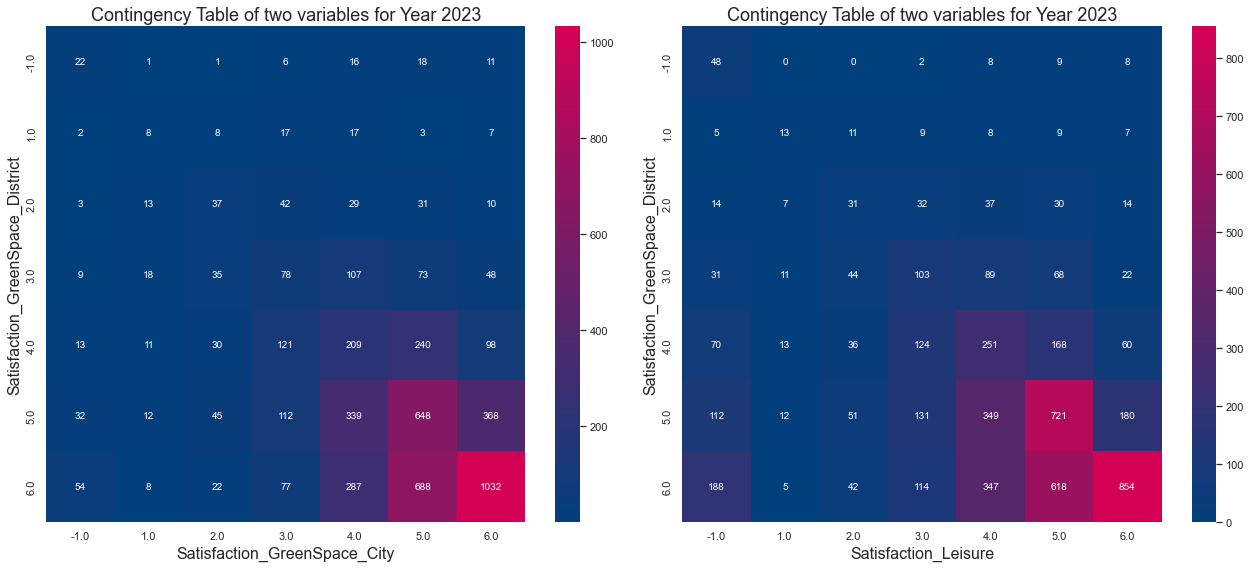

In [11]:
# filter data for the year 2023
df_2023 = df[df['Year'] == 2023]

# define the custom colors for the heatmap based on https://www.zh.ch/de/webangebote-entwickeln-und-gestalten/inhalt/designsystem/design-grundlagen/farben.zhweb-noredirect.zhweb-cache.html?
custom_cmap = sns.blend_palette(["#00407C", "#D40053"], as_cmap=True)

# function to create and plot a heatmap for given variables
def plot_heatmap(var1, var2, ax):
    # create a contingency table
    contingency_table_all = pd.crosstab(df_2023[var1], df_2023[var2])
    
    # plot the heatmap
    sns.heatmap(contingency_table_all, annot=True, cmap=custom_cmap, fmt='d', ax=ax)
    ax.set_title(f'Contingency Table of two variables for Year 2023', fontsize=18)
    ax.set_xlabel(var2, fontsize=16)
    ax.set_ylabel(var1, fontsize=16)

# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# plot the first heatmap: Satisfaction_GreenSpace_District vs Satisfaction_GreenSpace_City
plot_heatmap('Satisfaction_GreenSpace_District', 'Satisfaction_GreenSpace_City', ax=axes[0])

# plot the second heatmap: Satisfaction_GreenSpace_District vs Satisfaction_Leisure
plot_heatmap('Satisfaction_GreenSpace_District', 'Satisfaction_Leisure', ax=axes[1])

# adjust layout
plt.tight_layout()
plt.show()

#### Interpretation

Die Kontingenztabellen, die als Heatmaps visualisiert wurden, zeigen die Beziehungen zwischen den Zufriedenheitsniveaus der Variablen im Jahr 2023. Jede Zelle stellt die Anzahl der Beobachtungen dar, die eine bestimmte Kombination der beiden Variablen ausmachen, und bietet so einen visuellen Einblick in deren Beziehung.

Die Analyse zeigt einen klaren Zusammenhang zwischen der Zufriedenheit mit Grünräumen im Quartier und der Zufriedenheit mit Grünanlagen in der Stadt: Personen, die mit einem Bereich zufrieden sind, neigen dazu, auch mit dem anderen zufrieden zu sein. Es gibt eine Tendenz, dass Personen, die mit den Parkanlagen im Quartier sehr zufrieden sind, etwas weniger zufrieden mit den städtischen Parks und Grünanlagen sind.

Generell sind Personen, die mit dem Grünraum im Quartier zufrieden sind, tendenziell auch mit den Freizeitmöglichkeiten zufrieden. Die Analyse zeigt jedoch insgesamt ein etwas niedrigeres Zufriedenheitsniveau bei dieser Variable.

# 3. Hypothesen

Dieser Abschnitt formuliert Hypothesen, die mithilfe statistischer Methoden validiert werden. Hierbei ist zu beachten, dass ordinale Variablen analysiert werden, bei denen eine natürliche Rangfolge besteht, jedoch die Distanz zwischen den Kategorien unregelmässig sein können. Daher wurden für die ersten beiden Hypothesen non-parametrische Methoden gewählt, die keine Wahrscheinlichkeitsverteilung der Daten voraussetzen.

Das Buch "Analysis of Ordinal Categorical Data" von Alan Agresti wurde als Nachschlagwerk verwendet: https://onlinelibrary.wiley.com/doi/book/10.1002/9780470594001

In [31]:
# filter out rows where variable has a value of -1
df_without_minus1 = df[(df['Satisfaction_GreenSpace_District'] != -1) & (df['Satisfaction_GreenSpace_City'] != -1) & (df['Satisfaction_Leisure'] != -1)] 

### 3.1 Hypothese 1

- Nullhypothese (H0): Es gibt keine Korrelation zwischen der Zufriedenheit mit dem Grünraum im Quartier und der Zufriedenheit mit dem Angebot an Grünanlagen und Parks in der Stadt.
- Alternativhypothese (H1): Es besteht eine Korrelation zwischen der Zufriedenheit mit dem Grünraum im Quartier und der Zufriedenheit mit dem Angebot an Grünanlagen und Parks in der Stadt.

Statistische Methode: Spearman-Korrelation, die die Monotonie der Beziehung zwischen den ordinalen Variablen bewertet. Eine perfekte Spearman-Korrelation von +1 oder -1 tritt auf, wenn jede der Variablen eine perfekte monotone Funktion der anderen ist.

In [38]:
# spearman correlation calculation
correlation, p_value_h1 = spearmanr(df_without_minus1['Satisfaction_GreenSpace_District'], df_without_minus1['Satisfaction_GreenSpace_City'])


print(f"Spearman's Korrelationskoeffizient: {correlation}")
print(f"P-Wert: {p_value_h1:.3f}")

Spearman's Korrelationskoeffizient: 0.4019650271473598
P-Wert: 0.000


#### Interpretation:

Ein Korrelationskoeffizient von etwa 0.4 deutet auf eine moderate positive Korrelation hin. Das bedeutet, dass Veränderungen in der Zufriedenheit mit dem Grünraum im Quartier tendenziell mit entsprechenden Veränderungen in der Zufriedenheit mit dem Angebot an Grünanlagen und Parks in der Stadt einhergehen.

Der sehr kleine P-Wert von 0.000, der kleiner als das übliche Signifikanzniveau von 0.05 ist, zeigt, dass die Nullhypothese abgelehnt wird. Dies unterstreicht die statistische Signifikanz der festgestellten Korrelation.

### 3.2 Hypothese 2

- Nullhypothese (H0): Es gibt keinen statistischen Zusammenhang zwischen der Zufriedenheit mit dem Grünraum im Quartier und der Zufriedenheit Freizeitgestaltung im Quartier.
- Alternativhypothese (H1): Es gibt einen statistischen Zusammenhang zwischen der Zufriedenheit mit dem Grünraum im Quartier und der Zufriedenheit Freizeitgestaltung im Quartier.

Statistische Methode: Der Chi-Quadrat-Unabhängigkeitstest wird angewendet, um zu untersuchen, ob zwei kategoriale Variablen voneinander abhängig sind. Die Annahmen für den Test umfassen eine Zufallsstichprobe, Unabhängigkeit der Beobachtungen zwischen den Kategorien der Variablen sowie gegenseitig ausschliessende Gruppen, um die Validität der statistischen Ergebnisse zu gewährleisten.

In [40]:
# create a contingency table
contingency_table = pd.crosstab(df_without_minus1['Satisfaction_GreenSpace_District'], df_without_minus1['Satisfaction_Leisure'])

# chi-square test
chi2, p_value_h2, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square: {chi2}")
print(f"P-Wert: {p_value_h2:.3f}")
print(f"Freiheitsgrade / Degrees of Freedom: {dof}")

Chi-Square: 5075.7327391457875
P-Wert: 0.000
Freiheitsgrade / Degrees of Freedom: 25


#### Interpretation:

Der hohe Chi-Quadrat-Wert deutet darauf hin, dass die beobachteten Häufigkeiten in der Kontingenztabelle signifikant von den erwarteten Häufigkeiten abweichen würden, wenn die Variablen unabhängig voneinander wären.

Mit einem P-Wert von 0.000 wird die Nullhypothese abgelehnt, was darauf hinweist, dass ein statistisch signifikanter Zusammenhang zwischen der Zufriedenheit mit dem Grünraum im Quartier und der Zufriedenheit mit der Freizeitgestaltung im Quartier besteht.

### 3.3 Hypothese 3 (Nicht abgeschlossenes Gedankenexperiment)

- Nullhypothese (H0): Es besteht kein Zusammenhang zwischen der Zufriedenheit mit dem Grünraum im Quartier und den Variablen Zufriedenheit mit Grünanlagen und Parks in der Stadt sowie Freizeitgestaltung im Quartier.

- Alternativhypothese (H1): Es besteht ein Zusammenhang zwischen der Zufriedenheit mit dem Grünraum im Quartier und den Variablen Zufriedenheit mit Grünanlagen und Parks in der Stadt sowie Freizeitgestaltung im Quartier.

Statistische Methode: Ordinale Logistische Regression. Diese Methode ermöglicht die simultane Modellierung mehrerer ordinaler Variablen, um ihren Einfluss zu untersuchen.

Anmerkung: Die Anwendung dieser komplexen Methode erfordert fundiertes Hintergrundwissen und sollte methodisch weiter verfeinert werden, um fundierte und abschliessende Schlussfolgerungen zu ziehen.

In [41]:
# define independent variables
X = df_without_minus1[['Satisfaction_GreenSpace_City', 'Satisfaction_Leisure']]

# define dependent variable
y = df_without_minus1['Satisfaction_GreenSpace_District']

# fit the ordinal logistic regression
ordinal_model = OrderedModel(y, X).fit(method='bfgs')

# print summary of results
print(ordinal_model.summary())

Optimization terminated successfully.
         Current function value: 1.204005
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
                                    OrderedModel Results                                    
Dep. Variable:     Satisfaction_GreenSpace_District   Log-Likelihood:                -16672.
Model:                                 OrderedModel   AIC:                         3.336e+04
Method:                          Maximum Likelihood   BIC:                         3.341e+04
Date:                              Tue, 02 Jul 2024                                         
Time:                                      10:59:11                                         
No. Observations:                             13847                                         
Df Residuals:                                 13840                                         
Df Model:                                         2                                 

#### Interpretation

Ein höherer Zufriedenheitswert bei den städtischen Grünflächen um 0,3287 Einheiten erhöht die Wahrscheinlichkeit, in eine höhere Kategorie der Zufriedenheit mit den Grünflächen im Stadtteil zu fallen. Dieser Zusammenhang ist statistisch signifikant (p < 0,05), was zeigt, dass eine höhere Zufriedenheit mit städtischen Grünflächen mit einer höheren Zufriedenheit im Stadtteil einhergeht.

Ebenso ist eine höhere Zufriedenheit mit Freizeitaktivitäten um 0,4068 Einheiten statistisch signifikant (p < 0,05) mit einer besseren Zufriedenheit mit den Grünflächen im Stadtteil verbunden.

Die Koeffizienten für die ordinalen Kategorien (1,0/2,0 bis 4,0/5,0) zeigen, wie sich die Wahrscheinlichkeit verändert, in höhere Zufriedenheitskategorien zu fallen. Zwischen den aufeinanderfolgenden Kategorien (1,0/2,0 bis 4,0/5,0) bestehen signifikante Unterschiede, was eine geordnete Beziehung widerspiegelt. Jedoch zeigt die Kategorie 5,0/6,0 keine signifikanten Unterschiede im Vergleich zur Kategorie 4, was auf eine Plateau-Wirkung in der Zufriedenheit hinweist.

# 4. Fazit und Ausblick

In dieser Analyse wurden die Variablen Zufriedenheit mit dem Grünraum im Quartier (F25, A3016ae01), Zufriedenheit mit dem Angebot an Grünanlagen und Parks (F4, A2004ac01) sowie Zufriedenheit mit der Freizeitgestaltung im Quartier (F25, A3016ad01) aus der Bevölkerungsbefragung der Stadt Zürich für die Jahre 2019, 2021 und 2023 untersucht. Die Daten wurden umfassend aufbereitet, visualisiert und statistische Methoden angewendet, um Hypothesen zu überprüfen.

StadtbewohnerInnen zeigen insgesamt hohe Zufriedenheit mit dem Grünraum im Quartier sowie mit dem Angebot an Grünanlagen und Parks in der Stadt, wobei letzteres etwas niedriger bewertet wurde. Möglicherweise wünschen sich die Bewohnerinnen und Bewohner einen grösseren Grünraum innerhalb der Stadt oder sind sich der vorhandenen Möglichkeiten nicht ausreichend bewusst. Eine Informationskampagne könnte hier Abhilfe schaffen. Das Freizeitangebot wurde ebenfalls positiv bewertet, wobei viele der Befragten keine konkrete Antwort gaben, was darauf hinweisen könnte, dass das Angebot nicht ausreichend bekannt oder genutzt wird. Eine gezielte Förderung könnte das Interesse und die Teilnahme am Freizeitangebot steigern.

Weitere Analysen zeigen eine starke Abhängigkeit zwischen der Zufriedenheit mit dem Grünraum im Quartier, den Grünanlagen in der Stadt und dem Freizeitangebot. Personen, die mit dem Grünraum im Quartier zufrieden sind, neigen auch dazu, mit den anderen beiden Variablen zufrieden zu sein.

Zeitaufwand: Für die Datenaufbereitung, Visualisierungen und die ersten beiden grundlegenden Hypothesentests wurden etwa 3 Stunden benötigt. Die Regressionsanalyse für die dritte Hypothese und der Feinschliff der Visualisierungen nahmen zusätzlich etwa 1 Stunde in Anspruch.

Als nächster Schritt sollte die Ordinale Logistische Regression weiter verfeinert werden. Zudem wäre eine Analyse unter Einbeziehung aller Variablen aus den Frageböcken 4 und 25 sowie persönlicher Informationen wie Alter, Geschlecht und Stadtbezirk interessant. Die Untersuchung von Entwicklungen über die Jahre hinweg könnte ebenfalls relevante Erkenntnisse liefern. Besonderes Augenmerk sollte auf die Variable 'pgewicht' gelegt werden, um repräsentative Aussagen über die gesamte Zürcher Bevölkerung zu ermöglichen. Die Visualisierungen könnten durch Interaktionen ergänzt und entsprechend dem Corporate Design der Stadt Zürich verbessert werden (siehe z.B. https://github.com/StatistikStadtZuerich/zuericssstyle).